# 0. Подготовка окружения (загрузка моделей + вспомогательные функции)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision.transforms as transforms
from torch import linalg as LA
import torch.nn as nn
import torch.nn.functional as F

import gc
from copy import deepcopy
import time
import clip

import sys
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")

Устройство: cuda


In [2]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
# Используем конкретный коммит для воспроизводимости
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch
%pip install -q -e .
%cd ..

# Устанавливаем CLIP от OpenAI (официальный репозиторий)
%pip install -q git+https://github.com/openai/CLIP.git

# Устанавливаем вспомогательные библиотеки
%pip install -q lpips pillow matplotlib tqdm gdown omegaconf

c:\MyPythonProjects\DLS_course1_2\stylegan2-ada-pytorch


fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


Note: you may need to restart the kernel to use updated packages.
c:\MyPythonProjects\DLS_course1_2


ERROR: file:///C:/MyPythonProjects/DLS_course1_2/stylegan2-ada-pytorch does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
sys.path.insert(0, 'stylegan2-ada-pytorch')

In [15]:
import dnnlib
import legacy

ffhq_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'

def load_stylegan2_generator(url, device):
    with dnnlib.util.open_url(url) as f:
        generator = legacy.load_network_pkl(f)['G_ema'].to(device)
    generator.eval()
    return generator

G_original = load_stylegan2_generator(ffhq_url, device)
G_frozen = deepcopy(G_original)
for param in G_frozen.parameters():
    param.requires_grad = False

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

In [16]:
def tensor_to_image(tensor):
    if tensor.ndim == 4:
        tensor = tensor[0]
    tensor = (tensor + 1) * 0.5
    tensor = torch.clamp(tensor, 0, 1)
    image = (tensor * 255).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)
    return Image.fromarray(image)

def preprocess_tensor_for_clip(tensor):
    tensor = (tensor + 1) * 0.5
    tensor = torch.nn.functional.interpolate(
        tensor, size=(224, 224), mode='bicubic', align_corners=False
    )
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(tensor.device)
    tensor = (tensor - mean) / std
    return tensor

def get_text_features(prompt, model, device):
    if isinstance(prompt, str):
        prompt = [prompt]
    prompts = [f"a photo of a person {p}" for p in prompt]
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

In [17]:
# В случае некритичных проблем с совместимостью CUDA, Visual Studio Build Tools и Torch
# этот код поможет для подавления вывода многочисленных предупреждений
import warnings

warnings.filterwarnings("ignore")

stylegan_path = os.path.abspath('stylegan2-ada-pytorch')
if stylegan_path not in sys.path:
    sys.path.insert(0, stylegan_path)

def apply_plugin_patches():
    try:
        from torch_utils.ops import upfirdn2d, bias_act

        def patched_upfirdn2d_init():
            return False

        def patched_bias_act_init():
            return False

        upfirdn2d._init = patched_upfirdn2d_init
        bias_act._init = patched_bias_act_init

        return True
    except Exception:
        return False

apply_plugin_patches()

True

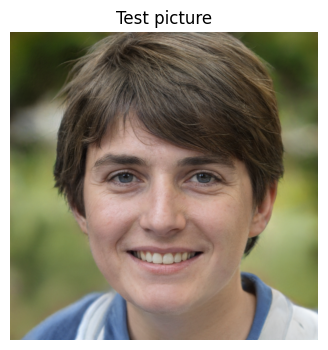

Признаки получены, размерность: torch.Size([1, 512])


In [41]:
# Проверяем работоспособность загруженной модели
z = torch.randn(1, G_original.z_dim).to(device)
with torch.no_grad():
    img = G_original(z, c=None, truncation_psi=0.7)

test_image = tensor_to_image(img)
plt.figure(figsize=(4, 4))
plt.imshow(test_image)
plt.axis('off')
plt.title('Test picture')
plt.show()

# Проверка получения признаков через CLIP
img_processed = preprocess_tensor_for_clip(img)
with torch.no_grad():
    img_features = clip_model.encode_image(img_processed)
    img_features = img_features / img_features.norm(dim=-1, keepdim=True)
print(f"Признаки получены, размерность: {img_features.shape}")

# 1. Анализ архитектуры модели

In [19]:
def get_generator_blocks_info(generator):
    blocks = []
    for name, module in generator.synthesis.named_modules():
        if hasattr(module, 'resolution'):
            resolution = module.resolution
            block_type = 'ToRGB' if 'torgb' in name.lower() else 'Conv'
            num_params = sum(p.numel() for p in module.parameters())
            blocks.append({
                'name': name,
                'resolution': resolution,
                'type': block_type,
                'num_params': num_params
            })
    blocks = sorted(blocks, key=lambda x: (x['resolution'], x['type']))
    return blocks

blocks_info = get_generator_blocks_info(G_original)
df_blocks = pd.DataFrame(blocks_info)

print("Структура генератора StyleGAN2 (FFHQ 1024px):")
print(f"Общее число блоков синтеза: {len(df_blocks)}")
print(f"Уникальные разрешения: {sorted(df_blocks['resolution'].unique().tolist())}")
print()
print(df_blocks[['name', 'resolution', 'type', 'num_params']].to_string(index=False))

total_params = df_blocks['num_params'].sum()
print(f"\nОбщее число параметров в синтезе: {total_params:,}")

Структура генератора StyleGAN2 (FFHQ 1024px):
Общее число блоков синтеза: 26
Уникальные разрешения: [4, 8, 16, 32, 64, 128, 256, 512, 1024]

       name  resolution type  num_params
         b4           4 Conv     2894852
   b4.conv1           4 Conv     2622465
         b8           8 Conv     5509125
   b8.conv0           8 Conv     2622465
   b8.conv1           8 Conv     2622465
        b16          16 Conv     5509125
  b16.conv0          16 Conv     2622465
  b16.conv1          16 Conv     2622465
        b32          32 Conv     5509125
  b32.conv0          32 Conv     2622465
  b32.conv1          32 Conv     2622465
        b64          64 Conv     5509125
  b64.conv0          64 Conv     2622465
  b64.conv1          64 Conv     2622465
       b128         128 Conv     2296069
 b128.conv0         128 Conv     1442561
 b128.conv1         128 Conv      721409
       b256         256 Conv      705669
 b256.conv0         256 Conv      426369
 b256.conv1         256 Conv      21324

In [20]:
# Функции для заморозки/разморозки слоев
def freeze_generator(generator):
    for param in generator.parameters():
        param.requires_grad = False

def unfreeze_by_resolution(generator, min_res, max_res):
    freeze_generator(generator)
    unfrozen_params = 0
    unfrozen_blocks = []
    for name, module in generator.synthesis.named_modules():
        if hasattr(module, 'resolution'):
            res = module.resolution
            if min_res <= res <= max_res:
                for param in module.parameters():
                    param.requires_grad = True
                    unfrozen_params += param.numel()
                unfrozen_blocks.append((name, res))
    return unfrozen_params, len(unfrozen_blocks), unfrozen_blocks

In [21]:
# Предобработка изображений
def get_clip_preprocess_exact():
    """
    Конвертирует тензор [-1, 1] -> [0, 1] -> 224px -> нормализация под ImageNet.
    """
    return transforms.Compose([
        transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0]),  # [-1,1] -> [0,1]
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                           std=[0.26862954, 0.26130258, 0.27577711])
    ])

clip_preprocess_exact = get_clip_preprocess_exact()

def directional_clip_loss_exact(img_frozen, img_train, text_source, text_target, clip_model):
    """
    Реализация direct clip loss
    """
    # Текстовые признаки
    text_source_tokens = clip.tokenize([f"a photo of a person {text_source}"]).to(device)
    text_target_tokens = clip.tokenize([f"a photo of a person {text_target}"]).to(device)

    with torch.no_grad():
        source_text_vec = clip_model.encode_text(text_source_tokens)
        target_text_vec = clip_model.encode_text(text_target_tokens)

    # Нормализуем текстовые векторы ДО вычитания
    source_text_vec = source_text_vec / LA.vector_norm(source_text_vec, ord=2, dim=-1, keepdim=True)
    target_text_vec = target_text_vec / LA.vector_norm(target_text_vec, ord=2, dim=-1, keepdim=True)

    # Признаки изображений
    img_frozen_proc = clip_preprocess_exact(img_frozen)
    img_train_proc = clip_preprocess_exact(img_train)

    frozen_image_vec = clip_model.encode_image(img_frozen_proc)
    image_vec = clip_model.encode_image(img_train_proc)

    # Нормализуем векторы изображений ДО вычитания
    frozen_image_vec = frozen_image_vec / LA.vector_norm(frozen_image_vec, ord=2, dim=-1, keepdim=True)
    image_vec = image_vec / LA.vector_norm(image_vec, ord=2, dim=-1, keepdim=True)

    # Направления (разность нормализованных векторов)
    di = image_vec - frozen_image_vec
    di = di / LA.vector_norm(di, ord=2, dim=-1, keepdim=True)

    dt = target_text_vec - source_text_vec
    dt = dt / LA.vector_norm(dt, ord=2, dim=-1, keepdim=True)

    # Косинусное сходство -> потеря (1 - cos)
    cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
    loss = (1 - cos_sim(di, dt)).mean()

    return loss

def identity_loss_l2(img_frozen, img_train):
    return F.mse_loss(img_train, img_frozen)

In [22]:
def train_generator_exact(
    generator_train,
    generator_frozen,
    min_res,
    max_res,
    text_source,
    text_target,
    steps=200,
    batch_size=2,
    lr=0.002,
    identity_weight=0.01,  # Очень маленький вес для сохранения структуры
    seed=RANDOM_SEED
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    unfreeze_by_resolution(generator_train, min_res, max_res)

    trainable_params = [p for p in generator_train.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr=lr, betas=(0.0, 0.999))

    losses_dir = []
    start_time = time.time()
    print(f"Стратегия: {min_res}-{max_res}px | шагов: {steps}")

    for step in range(steps):
        z = torch.randn(batch_size, generator_train.z_dim).to(device)
        with torch.no_grad():
            img_frozen = generator_frozen(z, c=None, truncation_psi=0.7)
        img_train = generator_train(z, c=None, truncation_psi=0.7)

        # clipdirect loss + identity loss
        loss_dir = directional_clip_loss_exact(
            img_frozen, img_train, text_source, text_target, clip_model
        )
        loss_id = identity_loss_l2(img_frozen, img_train)
        loss = loss_dir + identity_weight * loss_id

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()

        losses_dir.append(loss_dir.item())

        if step % 50 == 0 or step == steps - 1:  # Вывод каждые 50 шаго
            elapsed = time.time() - start_time
            remaining = elapsed / (step + 1) * (steps - step - 1) if step > 0 else 0  # Расчет оставшегося времени на основе прошедших итераций
            print(f"  Шаг {step+1:3d}/{steps} | loss_dir: {loss_dir.item():.4f} | осталось: ~{remaining/60:.1f} мин", flush=True)

    total_time = time.time() - start_time
    print(f"  Завершено за {total_time/60:.1f} мин")

    return losses_dir, total_time

In [ ]:
# Запуск экспериментов по оценке важности блоков
strategies = [
    ("early", 4, 32),
    ("medium", 64, 256),
    ("all", 4, 1024)
]

# Контрастные промпты для заметных изменений
text_source = "photo"
text_target = "anime drawing"

results = {}

print("АНАЛИЗ ВАЖНОСТИ БЛОКОВ")
print(f"Промпты: '{text_source}' -> '{text_target}'")
print("Шагов: 200 | batch: 2 | lr: 0.002 | identity_weight: 0.01\n")

for strategy_name, min_res, max_res in strategies:
    torch.cuda.empty_cache()
    gc.collect()

    G_exp = deepcopy(G_original)
    G_exp = G_exp.to(device)
    G_exp.train()

    losses_dir, train_time = train_generator_exact(
        G_exp, G_frozen, min_res, max_res,
        text_source, text_target,
        steps=200, batch_size=2, lr=0.002,
        identity_weight=0.01,
    )

    results[strategy_name] = {
        'generator': G_exp,
        'losses_dir': losses_dir,
        'train_time': train_time,
        'min_res': min_res,
        'max_res': max_res
    }

    torch.save(G_exp.state_dict(), f'models/G_{strategy_name}.pt')
    print(f"  Веса сохранены: models/G_{strategy_name}.pt\n")

    del G_exp
    torch.cuda.empty_cache()
    gc.collect()

АНАЛИЗ ВАЖНОСТИ БЛОКОВ
Промпты: 'photo' -> 'anime drawing'
Шагов: 200 | batch: 2 | lr: 0.002 | identity_weight: 0.01

Стратегия: 4-32px | шагов: 200
  Шаг   1/200 | loss_dir: 1.0137 | осталось: ~0.0 мин
  Шаг  51/200 | loss_dir: 0.8301 | осталось: ~0.9 мин
  Шаг 101/200 | loss_dir: 0.8623 | осталось: ~0.6 мин
  Шаг 151/200 | loss_dir: 0.8750 | осталось: ~0.3 мин
  Шаг 200/200 | loss_dir: 0.8018 | осталось: ~0.0 мин
  Завершено за 1.1 мин
  Веса сохранены: G_early.pt

Стратегия: 64-256px | шагов: 200
  Шаг   1/200 | loss_dir: 1.0137 | осталось: ~0.0 мин
  Шаг  51/200 | loss_dir: 0.7100 | осталось: ~0.9 мин
  Шаг 101/200 | loss_dir: 0.7324 | осталось: ~0.6 мин
  Шаг 151/200 | loss_dir: 0.7251 | осталось: ~0.3 мин
  Шаг 200/200 | loss_dir: 0.6880 | осталось: ~0.0 мин
  Завершено за 1.2 мин
  Веса сохранены: G_medium.pt

Стратегия: 4-1024px | шагов: 200
  Шаг   1/200 | loss_dir: 1.0137 | осталось: ~0.0 мин
  Шаг  51/200 | loss_dir: 0.6968 | осталось: ~1.1 мин
  Шаг 101/200 | loss_dir: 0.69

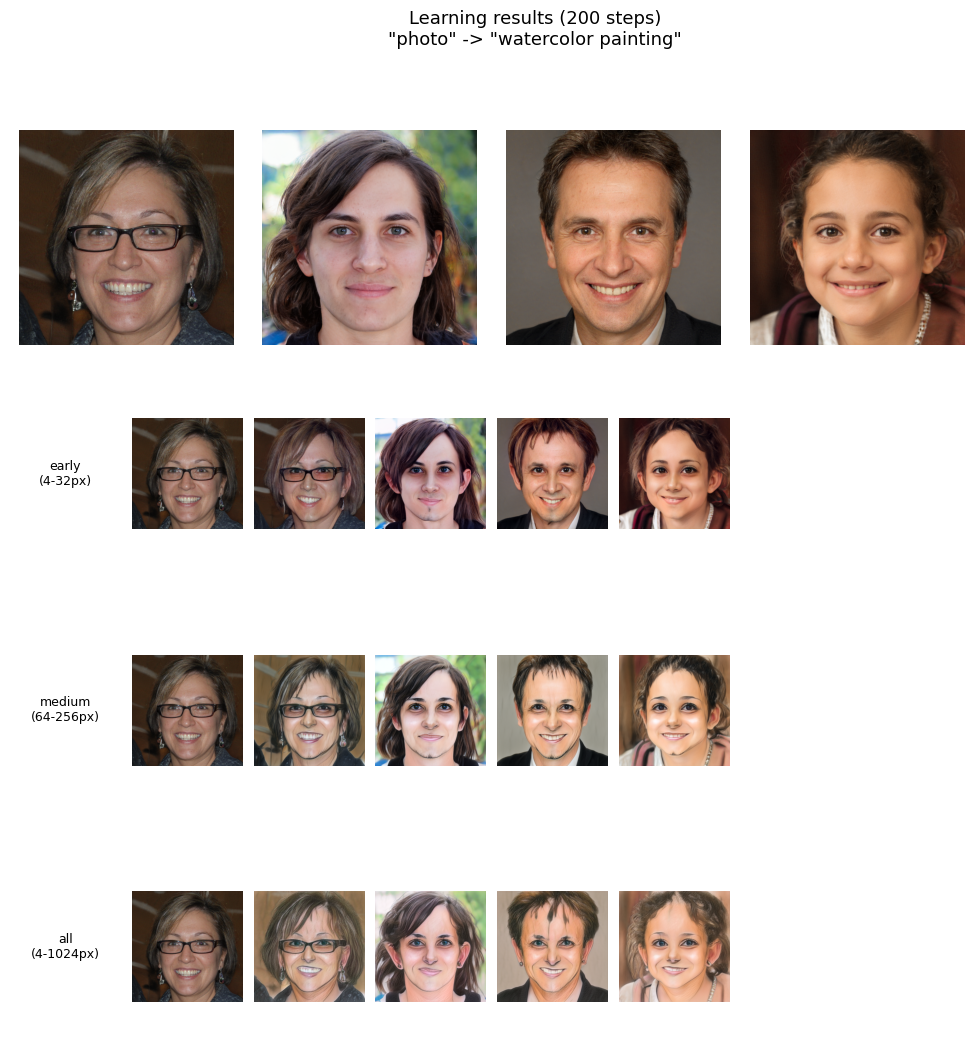

In [42]:
# Визуализируем результаты экспериментов
def load_generator_eval(strategy_name):
    G = deepcopy(G_original)
    G.load_state_dict(torch.load(f'G_{strategy_name}.pt'))
    G = G.to(device)
    G.eval()
    return G

z_fixed = torch.randn(4, G_original.z_dim).to(device)

with torch.no_grad():
    imgs_base = G_frozen(z_fixed, c=None, truncation_psi=0.7)

fig = plt.figure(figsize=(14, 3 * (len(strategies) + 1)))
gs = fig.add_gridspec(len(strategies) + 1, 9, hspace=0.1, wspace=0.1)

# Базовые изображения
for i in range(4):
    ax = fig.add_subplot(gs[0, 2*i:2*i+2])
    img = tensor_to_image(imgs_base[i])
    ax.imshow(img)
    ax.axis('off')
    if i == 0:
        ax.set_ylabel('Базовые', fontsize=10, fontweight='bold', rotation=0, labelpad=40)

# Результаты
strategy_names_display = {
    "early": f"early\n(4-{results['early']['max_res']}px)",
    "medium": f"medium\n(64-{results['medium']['max_res']}px)",
    "all": f"all\n(4-{results['all']['max_res']}px)"
}

for idx, strategy_name in enumerate(strategies):
    G_after = load_generator_eval(strategy_name[0])

    with torch.no_grad():
        imgs_after = G_after(z_fixed, c=None, truncation_psi=0.7)

    # Подпись стратегии
    ax_label = fig.add_subplot(gs[idx + 1, 0])
    ax_label.text(0.5, 0.5, strategy_names_display[strategy_name[0]],
                  ha='center', va='center', fontsize=9)
    ax_label.axis('off')

    # Базовое изображение для сравнения
    ax_base = fig.add_subplot(gs[idx + 1, 1])
    img_base = tensor_to_image(imgs_base[0])
    ax_base.imshow(img_base)
    ax_base.axis('off')

    # Результаты
    for i in range(4):
        ax = fig.add_subplot(gs[idx + 1, i + 2])
        img_after = tensor_to_image(imgs_after[i])
        ax.imshow(img_after)
        ax.axis('off')

    del G_after
    torch.cuda.empty_cache()

plt.suptitle(f'Learning results (200 steps)\n"{text_source}" -> "{text_target}"',
             fontsize=13)
plt.show()

In [25]:
# Функция для расчета косинусной близости
def evaluate_clip_similarity(generator, text_target, num_samples=8, batch_size=2, seed=RANDOM_SEED):
    """
    Оценивает косинусное сходство с целевым промптом (выше - лучше).
    """
    torch.manual_seed(seed)
    total_similarity = 0.0
    batches = num_samples // batch_size

    text_tokens = clip.tokenize([f"a photo of a person {text_target}"]).to(device)
    with torch.no_grad():
        text_feat = clip_model.encode_text(text_tokens)
        text_feat = text_feat / LA.vector_norm(text_feat, ord=2, dim=-1, keepdim=True)

    for _ in range(batches):
        z = torch.randn(batch_size, generator.z_dim).to(device)
        with torch.no_grad():
            imgs = generator(z, c=None, truncation_psi=0.7)
            imgs_proc = clip_preprocess_exact(imgs)
            img_feats = clip_model.encode_image(imgs_proc)
            img_feats = img_feats / LA.vector_norm(img_feats, ord=2, dim=-1, keepdim=True)
            similarity = (img_feats * text_feat).sum(dim=-1).mean().item()
            total_similarity += similarity

        del z, imgs, imgs_proc, img_feats
        torch.cuda.empty_cache()

    avg_similarity = total_similarity / batches
    return avg_similarity

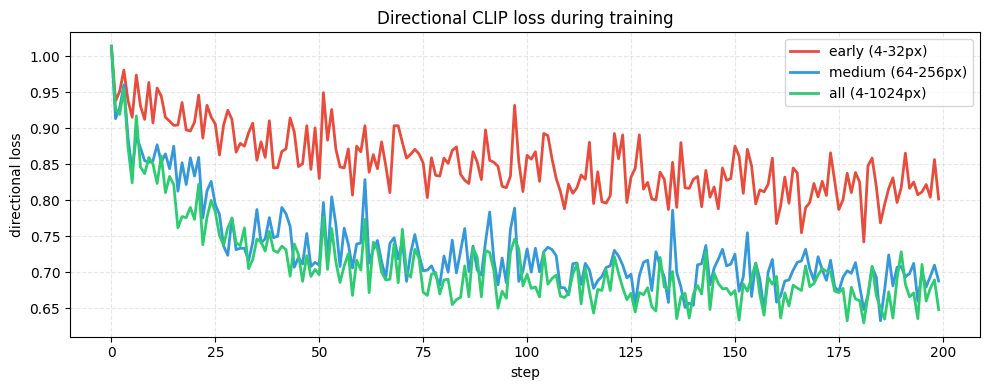

In [26]:
# График потерь
fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (strategy_name, _, _) in enumerate(strategies):
    losses = results[strategy_name]['losses_dir']
    ax.plot(losses, label=f"{strategy_name} ({results[strategy_name]['min_res']}-{results[strategy_name]['max_res']}px)",
            color=colors[idx], linewidth=2)

ax.set_xlabel('step')
ax.set_ylabel('directional loss')
ax.set_title('Directional CLIP loss during training')
ax.legend()
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Обучение выбранных слоев

In [27]:
def train_final_model(
    generator_train,
    generator_frozen,
    min_res,
    max_res,
    text_source,
    text_target,
    steps=500,
    batch_size=4,
    lr=0.002,
    identity_weight=0.01,
    seed=RANDOM_SEED
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    unfreeze_by_resolution(generator_train, min_res, max_res)

    trainable_params = [p for p in generator_train.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr=lr, betas=(0.0, 0.999))

    losses = []
    start_time = time.time()
    print(f"Обучение: '{text_source}' -> '{text_target}'")
    print(f"Слои: {min_res}-{max_res}px | шагов: {steps} | batch: {batch_size}")

    for step in range(steps):
        z = torch.randn(batch_size, generator_train.z_dim).to(device)
        with torch.no_grad():
            img_frozen = generator_frozen(z, c=None, truncation_psi=0.7)
        img_train = generator_train(z, c=None, truncation_psi=0.7)

        loss_dir = directional_clip_loss_exact(
            img_frozen, img_train, text_source, text_target, clip_model
        )
        loss_id = identity_loss_l2(img_frozen, img_train)
        loss = loss_dir + identity_weight * loss_id

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()

        losses.append(loss_dir.item())

        if step % 100 == 0 or step == steps - 1:
            elapsed = time.time() - start_time
            remaining = elapsed / (step + 1) * (steps - step - 1) if step > 0 else 0
            print(f"  Шаг {step+1:3d}/{steps} | loss_dir: {loss_dir.item():.4f} | осталось: ~{remaining/60:.1f} мин", flush=True)

    total_time = time.time() - start_time
    print(f"  Завершено за {total_time/60:.1f} мин\n")

    return losses, total_time

In [ ]:
# Выбранная стратегия на основе анализа блоков
min_res, max_res = 64, 256

# Три целевых домена
prompts = [
    ("photo", "sketch"),
    ("photo", "anime drawing"),
    ("photo", "watercolor painting")
]

final_models = {}
seed = RANDOM_SEED

print("ОБУЧЕНИЕ ФИНАЛЬНЫХ МОДЕЛЕЙ (стратегия: 64-256px)")
print()

for text_source, text_target in prompts:
    torch.cuda.empty_cache()

    G_train = deepcopy(G_original)
    G_train = G_train.to(device)
    G_train.train()

    losses, train_time = train_final_model(
        G_train, G_frozen, min_res, max_res,
        text_source, text_target,
        steps=500, batch_size=4, lr=0.002,
        identity_weight=0.01,
        seed=seed
    )

    model_key = text_target.replace(" ", "_")
    final_models[model_key] = {
        'generator': G_train,
        'losses': losses,
        'train_time': train_time,
        'source': text_source,
        'target': text_target
    }

    # Сохранение весов
    filename = f'models/G_{model_key}.pt'
    torch.save(G_train.state_dict(), filename)
    print(f"  Веса сохранены: {filename}\n")

    seed += 1  # Разные сиды для разных доменов

torch.cuda.empty_cache()

ОБУЧЕНИЕ ФИНАЛЬНЫХ МОДЕЛЕЙ (стратегия: 64-256px)

Обучение: 'photo' -> 'sketch'
Слои: 64-256px | шагов: 500 | batch: 4
  Шаг   1/500 | loss_dir: 0.9844 | осталось: ~0.0 мин
  Шаг 101/500 | loss_dir: 0.6748 | осталось: ~59.6 мин
  Шаг 201/500 | loss_dir: 0.6372 | осталось: ~44.9 мин
  Шаг 301/500 | loss_dir: 0.6387 | осталось: ~29.9 мин
  Шаг 401/500 | loss_dir: 0.6211 | осталось: ~14.9 мин
  Шаг 500/500 | loss_dir: 0.6416 | осталось: ~0.0 мин
  Завершено за 75.3 мин

  Веса сохранены: G_sketch.pt

Обучение: 'photo' -> 'anime drawing'
Слои: 64-256px | шагов: 500 | batch: 4
  Шаг   1/500 | loss_dir: 1.0166 | осталось: ~0.0 мин
  Шаг 101/500 | loss_dir: 0.6719 | осталось: ~28.7 мин
  Шаг 201/500 | loss_dir: 0.6787 | осталось: ~20.3 мин
  Шаг 301/500 | loss_dir: 0.6538 | осталось: ~13.3 мин
  Шаг 401/500 | loss_dir: 0.6270 | осталось: ~6.5 мин
  Шаг 500/500 | loss_dir: 0.6138 | осталось: ~0.0 мин
  Завершено за 32.8 мин

  Веса сохранены: G_anime_drawing.pt

Обучение: 'photo' -> 'watercolo

# 3.1 Редактирование сгенерированных изображений (проверка работоспосбности обученных моделей)

In [ ]:
def generate_comparison_grid(generator_frozen, generator_trained, seed=RANDOM_SEED, num_images=4):
    torch.manual_seed(seed)
    z = torch.randn(num_images, generator_frozen.z_dim).to(device)

    with torch.no_grad():
        imgs_frozen = generator_frozen(z, c=None, truncation_psi=0.7)
        imgs_trained = generator_trained(z, c=None, truncation_psi=0.7)

    return imgs_frozen, imgs_trained

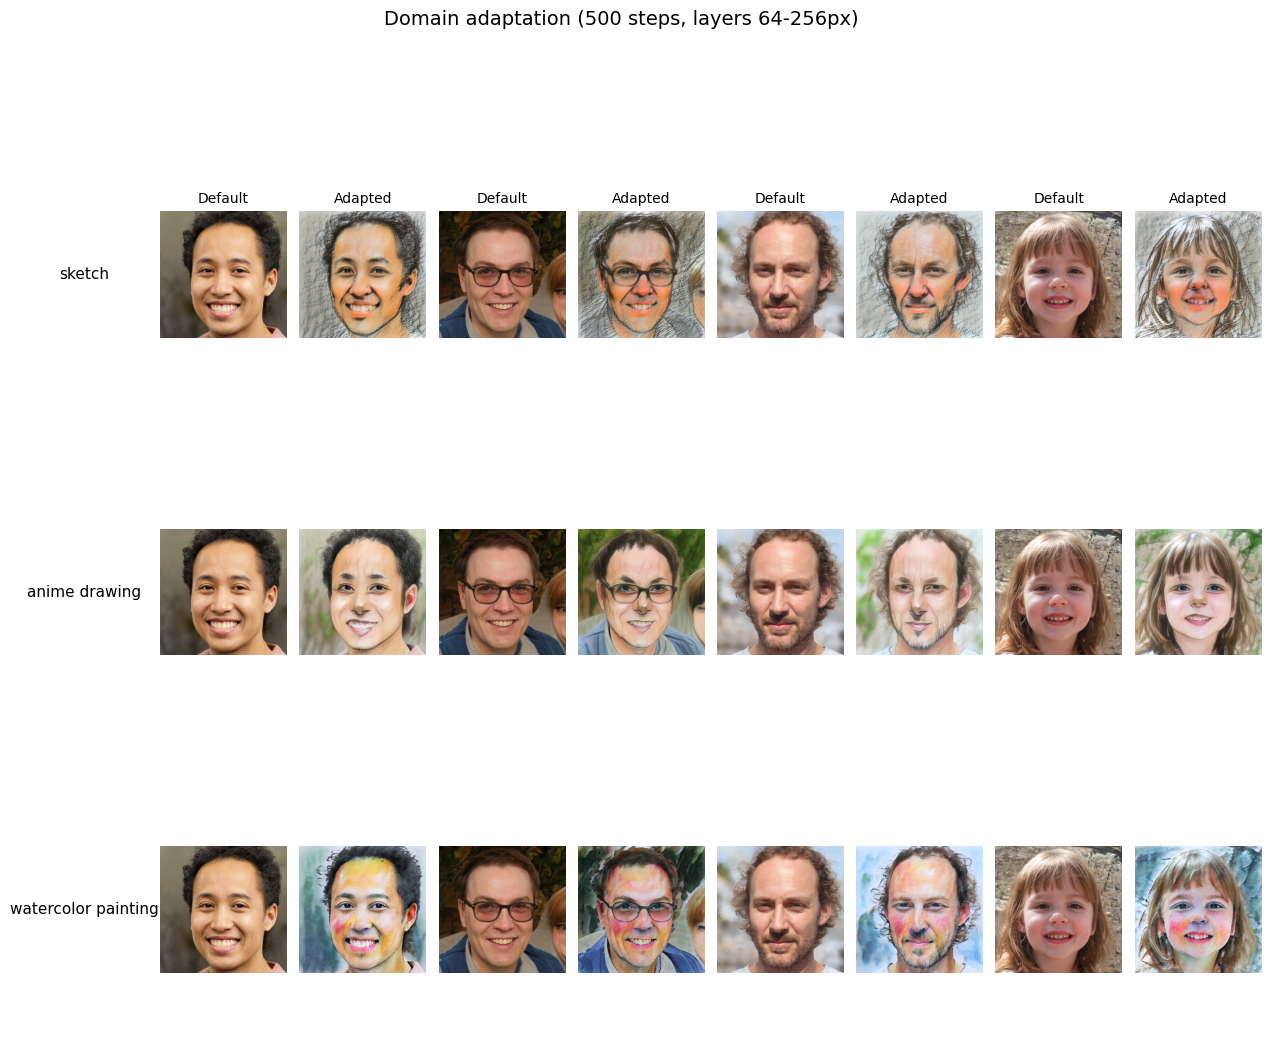

In [ ]:
# Фиксированный сид для сравнения
seed_vis = 123
num_images = 4

fig = plt.figure(figsize=(16, 4 * len(final_models)))
gs = fig.add_gridspec(len(final_models), num_images * 2 + 1, hspace=0.1, wspace=0.1)

for idx, (model_key, model_data) in enumerate(final_models.items()):
    G_trained = model_data['generator']
    text_target = model_data['target']

    imgs_frozen, imgs_trained = generate_comparison_grid(
        G_frozen, G_trained, seed=seed_vis, num_images=num_images
    )

    # Подпись домена
    ax_label = fig.add_subplot(gs[idx, 0])
    ax_label.text(0.5, 0.5, text_target, ha='center', va='center',
                 fontsize=11)
    ax_label.axis('off')

    # Изображения "до" и "после"
    for i in range(num_images):
        # До (базовый генератор)
        ax_before = fig.add_subplot(gs[idx, 2*i + 1])
        img_before = tensor_to_image(imgs_frozen[i])
        ax_before.imshow(img_before)
        ax_before.axis('off')
        if idx == 0:
            ax_before.set_title('Default', fontsize=10)

        # После (обученный генератор)
        ax_after = fig.add_subplot(gs[idx, 2*i + 2])
        img_after = tensor_to_image(imgs_trained[i])
        ax_after.imshow(img_after)
        ax_after.axis('off')
        if idx == 0:
            ax_after.set_title('Adapted', fontsize=10)

plt.suptitle('Domain adaptation (500 steps, layers 64-256px)',
             fontsize=14)
plt.savefig('pictures/domain_adaptation_results.png', bbox_inches='tight')
plt.show()

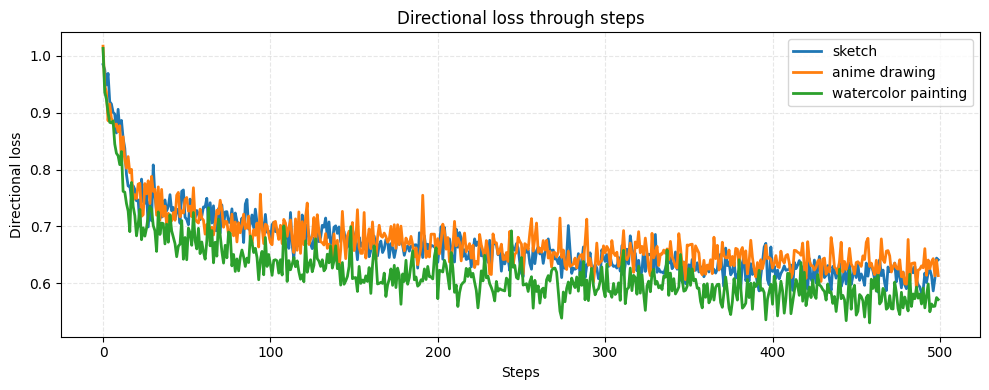

In [ ]:
# Графики потерь
fig, ax = plt.subplots(figsize=(10, 4))

for model_key, model_data in final_models.items():
    losses = model_data['losses']
    ax.plot(losses, label=model_data['target'], linewidth=2)

ax.set_xlabel('Steps')
ax.set_ylabel('Directional loss')
ax.set_title('Directional CLIP loss during training')
ax.legend()
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('pictures/training_losses.png', dpi=150, bbox_inches='tight')
plt.show()